In [1]:
import syft as sy
import torch
from tools import models
import numpy as np
import pandas as pd
import time

sy.load('opacus')
np.random.seed(42) # The meaning of life!

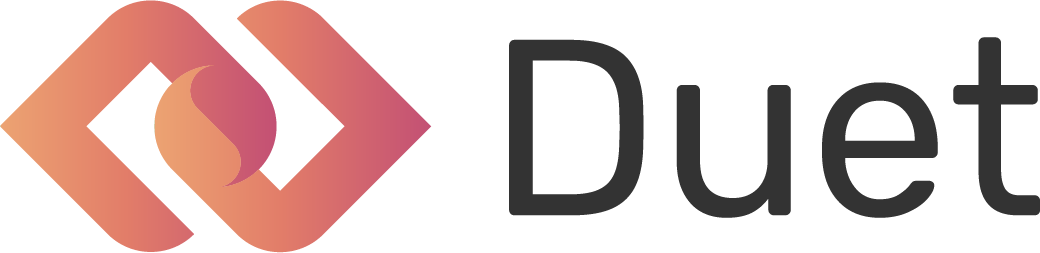

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

In [3]:
# Getting the pionters to the data
time.sleep(31) # Sleep timer so you can just press restart on both notebooks without caring (might need to be adjusted)

train_data_ptr = duet.store[0]
train_labels_ptr = duet.store[1]

test_data_ptr = duet.store[2]
test_labels_ptr = duet.store[3]

In [4]:
# Constants for tracking purposes
MODEL = 'Deep2DNet'
DATASET = 'MedNIST'
TRACKING = True # Whether or not this run should be tracked in the results csv file
DP = False # Whether or not Differential Privacy should be applied

# Parameters for training and Differential Privacy
BATCH_SIZE = 100
EPOCHS = 30
LEARNING_RATE = 0.003 if DP else 0.001

DELTA = 1e-4 # Set to be less then the inverse of the size of the training dataset (from https://opacus.ai/tutorials/building_image_classifier)
NOISE_MULTIPLIER = 2.0 # The amount of noise sampled and added to the average of the gradients in a batch (from https://opacus.ai/tutorials/building_image_classifier)
MAX_GRAD_NORM = 1.2 # The maximum L2 norm of per-sample gradients before they are aggregated by the averaging step (from https://opacus.ai/tutorials/building_image_classifier)

length = len(train_data_ptr)
SAMPLE_SIZE = length - length % BATCH_SIZE # NOTE: Current implementation only trains data in multiples of batch size. So BATCH_SIZE % LENGTH amount of data will not be used for training.
SAMPLE_RATE = BATCH_SIZE / SAMPLE_SIZE

# Getting remote and local instances
local_model = models.Deep2DNet(torch)
remote_model = local_model.send(duet)
remote_torch = duet.torch
remote_opacus = duet.opacus

# Setting device to train on
cuda_available = remote_torch.cuda.is_available().get(request_block=True, reason='Need to check for available GPU!')
if cuda_available:
    device = remote_torch.device('cuda:0')
    remote_model.cuda(device)
else:
    device = remote_torch.device('cpu')
    remote_model.cpu()

# Optimizer and Loss Function
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=LEARNING_RATE) # without DP: 0.0001 // with DP: 0.002-0.003
loss_function = remote_torch.nn.CrossEntropyLoss()

# Setting up Differential Privacy Engine
if DP:
    privacy_engine_ptr = remote_opacus.privacy_engine.PrivacyEngine(
        remote_model.real_module, sample_rate=SAMPLE_RATE,
        noise_multiplier=NOISE_MULTIPLIER, max_grad_norm=MAX_GRAD_NORM
    )
    privacy_engine_ptr.attach(optim)
else:
    privacy_engine_ptr = None


In [5]:

def train(batch_size, epochs, model, 
          torch_ref, optim, loss_function, 
          train_data, train_labels, test_data, 
          test_labels, input_shape, device, privacy_engine=None):
    
    # Variables to track
    losses = [] # Training losses per batch per epoch
    test_accs = []
    test_losses = [] # Test losses per epoch
    epsilons = [] 
    alphas = []
    epoch_times = [] # Training times for each epoch
    best_acc_loss = (0, 0)
    best_model = None
    
    # Divide dataset into batches (sadly remote DataLoaders aren't yet a thing in pysyft)
    length = len(train_data)
    
    if length % batch_size != 0:
        cut_data = train_data[:length - length % batch_size]
        cut_labels = train_labels[:length - length % batch_size]
        
    shape = [-1, batch_size]
    shape.extend(input_shape)
    
    batch_data = cut_data.view(shape)
    batch_labels = cut_labels.view(-1, batch_size)
    
    # Prepare indices for randomization of order for each epoch
    indices = np.arange(int(length / batch_size))
    
    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = []
        
        model.train()
        
        np.random.shuffle(indices)
        
        print(f'###### Epoch {epoch + 1} ######')
        for i in indices:
            optim.zero_grad()
            
            output = model(batch_data[int(i)].to(device))
            
            loss = loss_function(output, batch_labels[int(i)].to(device))
            loss_item = loss.item()
            
            if model.is_local:
                loss_value = loss_item
            else:
                loss_value = loss_item.get(reason="To evaluate training progress", request_block=True, timeout_secs=5)
            print(f'Training Loss: {loss_value}')
            epoch_loss.append(loss_value)
        
            loss.backward()
            optim.step()
        
        # Checking our privacy budget
        if privacy_engine is not None:
            epsilon_tuple = privacy_engine.get_privacy_spent(DELTA)
            epsilon_ptr = epsilon_tuple[0].resolve_pointer_type()
            best_alpha_ptr = epsilon_tuple[1].resolve_pointer_type()

            epsilon = epsilon_ptr.get(
                reason="So we dont go over it",
                request_block=True,
                timeout_secs=5
            )
            best_alpha = best_alpha_ptr.get(
                reason="So we dont go over it",
                request_block=True,
                timeout_secs=5
            )
            if epsilon is None:
                epsilon = float("-inf")
            if best_alpha is None:
                best_alpha = float("-inf")
            print(
                f"(ε = {epsilon:.2f}, δ = {DELTA}) for α = {best_alpha}"
            )
            epsilons.append(epsilon)
            alphas.append(best_alpha)
    
        test_acc, test_loss = test(model, loss_function, torch_ref, test_data, test_labels, device)
        print(f'Test Accuracy: {test_acc} ---- Test Loss: {test_loss}')
        
        epoch_end = time.time()
        print(f"Epoch time: {float(epoch_end - epoch_start)} seconds")
        
        losses.append(epoch_loss)
        epoch_times.append(float(epoch_end - epoch_start))
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        
    return losses, test_accs, test_losses, epsilons, alphas, epoch_times
                   
            
def test(model, loss_function, torch_ref, data, labels, device):
    model.eval()
    
    data = data.to(device)
    labels = labels.to(device)
    length = len(data)
    
    with torch_ref.no_grad():
        output = model(data)
        test_loss = loss_function(output, labels)
        prediction = output.argmax(dim=1)
        total = prediction.eq(labels).sum().item()
        
    acc_ptr = total / length
    if model.is_local:
        acc = acc_ptr
        loss = test_loss.item()
    else:
        acc = acc_ptr.get(reason="To evaluate training progress", request_block=True, timeout_secs=5)
        loss = test_loss.item().get(reason="To evaluate training progress", request_block=True, timeout_secs=5)

    return acc, loss

In [6]:
losses, test_accs, test_losses, epsilons, alphas, epoch_times = train(BATCH_SIZE, EPOCHS, 
                                                                      remote_model, remote_torch,
                                                                      optim, loss_function, 
                                                                      train_data_ptr, train_labels_ptr, 
                                                                      test_data_ptr, test_labels_ptr, 
                                                                      [1, 64, 64], device, privacy_engine_ptr)

###### Epoch 1 ######
Training Loss: 1.7919745445251465
Training Loss: 1.7790114879608154
Training Loss: 2.3523731231689453
Training Loss: 1.7817648649215698
Training Loss: 1.7911075353622437
Training Loss: 1.7917263507843018
Training Loss: 1.796738624572754
Training Loss: 1.78407621383667
Training Loss: 1.7510606050491333
Training Loss: 1.699795126914978
Training Loss: 1.6799260377883911
Training Loss: 1.6558696031570435
Training Loss: 1.6099357604980469
Training Loss: 1.5818684101104736
Training Loss: 1.5260014533996582
Training Loss: 1.4664521217346191
Training Loss: 1.3777302503585815
Training Loss: 1.7096197605133057
Test Accuracy: 0.42718446254730225 ---- Test Loss: 1.3412050008773804
Epoch time: 6.171245813369751 seconds
###### Epoch 2 ######
Training Loss: 1.3024133443832397
Training Loss: 1.096971869468689
Training Loss: 1.11940336227417
Training Loss: 1.0986227989196777
Training Loss: 1.0980160236358643
Training Loss: 1.1676851511001587
Training Loss: 1.0450563430786133
Train

In [7]:
from tools import datasets
# TODO!: Use best model for validation
# Sadly very redundant since remotly tracking best model is not easily possible and therefore just last model is used for validation
# Evalutating the model locally with the validation data
eval_model = remote_model.get(request_block=True, reason="Needed for local evaluation!")
eval_model.cuda(torch.device('cuda:0'))
loss_function = torch.nn.CrossEntropyLoss()

# Higher sample_size here as on DO side will ensure that it is actually data that is not in train or test set!
_, _, val_ds = datasets.Loader.load_MedNIST(sample_size=0.1, test_size=0.1, val_size=0.05)
val_data, val_labels = val_ds.as_tensor()

val_acc, val_loss = test(eval_model, loss_function, torch, val_data, val_labels, torch.device('cuda:0'))

print(f'Validation Accuracy: {val_acc} ---- Validation Loss: {val_loss}')

Validation Accuracy: 0.9829931972789115 ---- Validation Loss: 0.044213008135557175


In [8]:
# Tracking all interesting variables and results in .csv file
if TRACKING:
    d = {
        'model': MODEL,
        'dataset': DATASET,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'train_sample_size': SAMPLE_SIZE,
        'test_sample_size': len(test_data_ptr),
        'val_sample_size': len(val_data),
        'delta': DELTA,
        'noise_multiplier': NOISE_MULTIPLIER,
        'max_grad_norm': MAX_GRAD_NORM,
        'dp_used': DP,
        'epsilons': epsilons,
        'alphas': alphas,
        'train_losses': losses,
        'test_accs': test_accs,
        'test_losses': test_losses,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'epoch_times': epoch_times
    }      
    df = pd.read_csv('./Results/1DS.csv')
    df = df.append(d, ignore_index=True)
    df.to_csv('./Results/1DS.csv', index=False)